In [1]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
#Get Data
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
#Get all curveballs
bbc = all_pitches[all_pitches['TaggedPitchType'].isin(['Curveball'])]
print(bbc.shape)

(19528, 167)


In [4]:
#Subset curveballs into platoon splits
bbc_rr = bbc[(bbc['PitcherThrows'] == 'Right') & (bbc['BatterSide'] == 'Right')]
bbc_rl = bbc[(bbc['PitcherThrows'] == 'Right') & (bbc['BatterSide'] == 'Left')]
bbc_lr = bbc[(bbc['PitcherThrows'] == 'Left') & (bbc['BatterSide'] == 'Right')]
bbc_ll = bbc[(bbc['PitcherThrows'] == 'Left') & (bbc['BatterSide'] == 'Left')]

print(bbc_rr.shape)
print(bbc_rl.shape)
print(bbc_lr.shape)
print(bbc_ll.shape)

(7407, 167)
(6008, 167)
(3804, 167)
(2305, 167)


In [5]:
#Whiffs
bbc_rr['whiff'] = np.where(bbc_rr['PitchCall']=='StrikeSwinging',1,0)
bbc_rl['whiff'] = np.where(bbc_rl['PitchCall']=='StrikeSwinging',1,0)
bbc_lr['whiff'] = np.where(bbc_lr['PitchCall']=='StrikeSwinging',1,0)
bbc_ll['whiff'] = np.where(bbc_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_8052\2943017200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbc_rr['whiff'] = np.where(bbc_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_8052\2943017200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbc_rl['whiff'] = np.where(bbc_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_8052\2943017200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [6]:
#Predictor Variables
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs. Righty Split

In [7]:
bbc_rr_X = bbc_rr[preds]
bbc_rr_y = bbc_rr['whiff']

In [8]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbc_rr_X, bbc_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.83%


ROC AUC: 0.5228


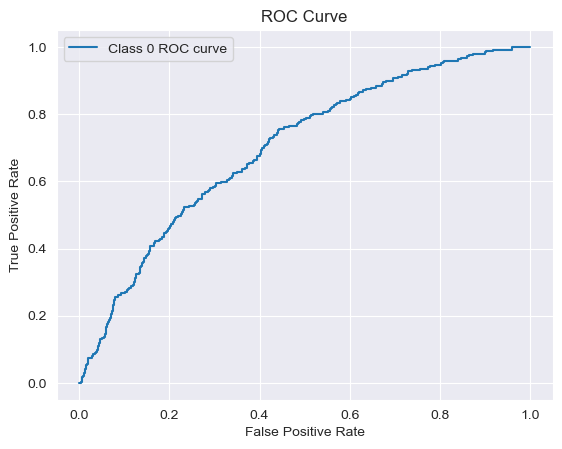

In [9]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [10]:
# Get unique values
unique_values = bbc_rr['Pitcher'].unique()


#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbc_rr[bbc_rr['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Vega, Christian' 'Hellmers, Will' 'Taylor, Grant'
 'Dutton, Samuel' 'Stone, Tyler' 'Hackett, Bryce' 'Boyd, Riley '
 'Mentzel, Kyler' 'Patel, Devon' 'Dannelley, Jackson' 'Clayton, Logan'
 'Marsh, Chandler' 'Miles, Spencer' 'Rustad, Carter' 'Gowen, Jack'
 'Smith, Cade' 'Hardin, Tyson' 'Van Alstine, Marcus' 'Parenteau, Matt'
 'Lambert, Carson' 'Allsup, Chase' 'Levy, Gabe' 'Corso, Vincent'
 'Holman, Luke' 'Sanders, Will' 'Hicks, James' 'Rodgers, Zachary'
 'Cota, Miles' 'Collins, Bryce' 'Hunt, KC' 'Wilkerson, Holden'
 'Inskeep, JT' 'Saunier, Grayson' 'Pizzico, Luke' 'German, Nestor'
 'Michel, Jake' 'Hess, Ben' 'Starnes, Jimmy' 'Smith, Kolten'
 'Mercer, Pace' 'Hall, Noah' 'Money, Blake' 'Gartman, Landon'
 'Riley, Will ' 'Colmery, Christian' 'Smith, Blake' 'Sinnard, Luke'
 'McNairy, Jacob' 'Subers, Kyle' 'Blatter, Brock' 'Gillespie, Blake'
 'Fortner, Trey' 'Mahoney, Jack' 'Dirito, Nick' 'Proctor, Nick'
 'Bybee, Ben' 'Tygart, Brady' 'Fanning, Hollis' 'Marono, Jason'
 'Hurd,

In [11]:
def rr_bbc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbc_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [12]:
#Stuff+ for selected pitchers Curveball in RHP v RHB split
rr_bbc_stuff('Tilly, Cameron')

149.16452

Righty vs. Lefty Split

In [13]:
bbc_rl_X = bbc_rl[preds]
bbc_rl_y = bbc_rl['whiff']

In [14]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbc_rl_X, bbc_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.61%


In [15]:
# Get unique values
unique_values = bbc_rl['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbc_rl[bbc_rl['Pitcher'] == value] for value in unique_values}

['Turnage, Easton' 'Hellmers, Will' 'Vega, Christian' 'Dutton, Samuel'
 'Stone, Tyler' 'Hackett, Bryce' 'Mentzel, Kyler' 'Patel, Devon'
 'Miles, Spencer' 'Marsh, Chandler' 'Rustad, Carter' 'Gowen, Jack'
 'Smith, Cade' 'Parenteau, Matt' 'Allsup, Chase' 'Levy, Gabe'
 'Corso, Vincent' 'Sanders, Will' 'Rodgers, Zachary' 'Wilkerson, Holden'
 'Inskeep, JT' 'Michel, Jake' 'Hess, Ben' 'Jones, Tanner' 'Smith, Kolten'
 'Mercer, Pace' 'Hall, Noah' 'Floyd, Ty' 'Money, Blake' 'Gartman, Landon'
 'Smith, Blake' 'Leaverton, Blake' 'Sinnard, Luke' 'Argomaniz, Brenden'
 'McNairy, Jacob' 'Subers, Kyle' 'Blatter, Brock' 'Gillespie, Blake'
 'Fortner, Trey' 'Mahoney, Jack' 'Dirito, Nick' 'Proctor, Nick'
 'Tygart, Brady' 'Hurd, Thatcher' 'Luckett, Nicholas' 'Kyles, Perry'
 'Hardin, Tyson' 'Siary, Evan' 'Quinn, JT' 'Algee, Jake' 'Tauzin, Kole'
 'Gelorme, Matt' 'Holman, Luke' 'Zarella, Tyler' 'Beasley, Josh'
 'Delic, Elvin' 'Smith, Travis' 'Harris, Shane' 'MacCauley, John'
 'Blunt, Jarrett' 'Hardman, Nate' 'Je

In [16]:
def rl_bbc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbc_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [17]:
#Stuff+ for selected pitchers Curveball in RHP v LHB split
rl_bbc_stuff('Tilly, Cameron')

62.101196

Lefty vs. Righty Split

In [18]:
bbc_lr_X = bbc_lr[preds]
bbc_lr_y = bbc_lr['whiff']

In [19]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbc_lr_X, bbc_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.05%


In [20]:
# Get unique values
unique_values = bbc_lr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbc_lr[bbc_lr['Pitcher'] == value] for value in unique_values}


['Adams, Aiden' 'LaCalameto, Kyle' 'Shapiro, Joe' 'Yntema, Graham'
 'Chronowski, Peter' 'Seiler, Ben' 'Hitt, Grayson' 'Furtado, Hunter'
 'Goldstein, Charlie' 'Keevan, LJ' 'Cooper, Riley' 'Johnston, Will'
 'Sullivan, Liam' 'Duke, Hayden' 'Wheeler, Trey' 'Rivas, Xavier'
 'Hogan, Kian' 'Nelson, Drew' 'Kraft, Ryan' 'Senders, Sammy'
 'Zielinski, Eli' 'Jette, Jacob' 'Morris, Zack' 'Fitzgibbons, Jake'
 'Nicholson, Gabe ' 'Bimbi, Jacob' 'Huff, Hollis' 'Parks, Michael'
 'Sechrist, Zander' 'Campbell, Tyler' 'Sales, Terence ' 'Becker, Matthew'
 'Sewell, JC' 'Warrick, Isaac' 'Dunn, Ross' 'Cheatham, Cole'
 'Davis, Alton' 'Evans Jr, Jarvis' 'Coady, Owen' 'Tobin, Will'
 'Holton, Carter' 'Manfredi, Mark' 'Wozniak, Brett' 'Chmielewski, Tom'
 'MacDonald, Caden' 'Bosma, Tyler' 'Gongora, Sebastian' 'Luikart, Jay'
 'Owen, Hunter' 'Hollan, Hunter' 'Coil, Parker' 'Espelin, Nate'
 'Tedesco, Jake' 'Manning, Timmy' 'Kane, Thomas' 'Rembisz, Ryan'
 'Futrell, Devin' 'Daugherty, Ryan' 'Connell, Kirby' 'Toney, Bryce

In [21]:
def lr_bbc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbc_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [24]:
#Stuff+ for selected pitchers Curveball in LHP v RHB split
lr_bbc_stuff('Caglianone, Jac')

193.87415

Lefty vs. Lefty Split

In [25]:
bbc_ll_X = bbc_ll[preds]
bbc_ll_y = bbc_ll['whiff']

In [26]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbc_ll_X, bbc_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.57%


In [27]:
# Get unique values
unique_values = bbc_ll['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: bbc_ll[bbc_ll['Pitcher'] == value] for value in unique_values}


['Walsh, Redmond' 'Johnston, Will' 'Adams, Aiden' 'LaCalameto, Kyle'
 'Shapiro, Joe' 'Yntema, Graham' 'Chronowski, Peter' 'Seiler, Ben'
 'Furtado, Hunter' 'Keevan, LJ' 'Morgan, Trey' 'Vail, Tommy'
 'Clifton, Harrison' 'Duke, Hayden' 'Szczepaniak, Drew' 'Light, Nathan'
 'Hogan, Kian' 'Nelson, Drew' 'Kraft, Ryan' 'Reinke, Brian' 'Jette, Jacob'
 'Nicholson, Gabe ' 'Huff, Hollis' 'Parks, Michael' 'Windham, Payton'
 'Campbell, Tyler' 'Sales, Terence ' 'Garcia, Jason' 'Cijntje, Jurrangelo'
 'Warrick, Isaac' 'Dunn, Ross' 'Tapper, Brock' 'Cheatham, Cole'
 'Evans Jr, Jarvis' 'Coady, Owen' 'Tobin, Will' 'Holton, Carter'
 'Manfredi, Mark' 'Wozniak, Brett' 'Ball, Connor' 'Sullivan, Liam'
 'Chmielewski, Tom' 'MacDonald, Caden' 'Gongora, Sebastian' 'Bosma, Tyler'
 'Becker, Matthew' 'Owen, Hunter' 'Espelin, Nate' 'Tedesco, Jake'
 'Bimbi, Jacob' 'Manning, Timmy' 'Kane, Thomas' 'Rembisz, Ryan'
 'Goldstein, Charlie' 'Cotto, Magdiel' 'Futrell, Devin' 'Sechrist, Zander'
 'Daugherty, Ryan' 'Connell, Kirby'

In [28]:
def ll_bbc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbc_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [30]:
#Stuff+ for selected pitchers Curveball in LHP v LHB split
ll_bbc_stuff('Caglianone, Jac')

253.66385